### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (2 балл)

4) Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями (1 балл)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.40MB/s]


In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

In [6]:
for image, cat in dataloader:
    break

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

In [8]:
28*28

784

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [10]:
generator = Generator()
discriminator = Discriminator()

In [11]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [12]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [13]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output, label.view(-1, 1))
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label.view(-1, 1))
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label.view(-1, 1))
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.22 errD_z: 0.08 errG: 2.65
Epoch:1 Iter: 200 errD_x: 0.41 errD_z: 0.08 errG: 2.87
Epoch:1 Iter: 300 errD_x: 0.35 errD_z: 0.14 errG: 2.32
Epoch:1 Iter: 400 errD_x: 0.14 errD_z: 0.12 errG: 2.30
Epoch:1 Iter: 500 errD_x: 0.08 errD_z: 0.07 errG: 2.83
Epoch:1 Iter: 600 errD_x: 0.21 errD_z: 0.08 errG: 2.77
Epoch:1 Iter: 700 errD_x: 0.19 errD_z: 0.09 errG: 2.56
Epoch:1 Iter: 800 errD_x: 0.34 errD_z: 0.05 errG: 3.17
Epoch:1 Iter: 900 errD_x: 0.06 errD_z: 0.13 errG: 2.54
Epoch:1 Iter: 1000 errD_x: 0.26 errD_z: 0.15 errG: 2.40
Epoch:1 Iter: 1100 errD_x: 0.21 errD_z: 0.11 errG: 2.68
Epoch:1 Iter: 1200 errD_x: 0.16 errD_z: 0.26 errG: 1.78
Epoch:1 Iter: 1300 errD_x: 0.13 errD_z: 0.24 errG: 2.00
Epoch:1 Iter: 1400 errD_x: 0.10 errD_z: 0.19 errG: 2.11
Epoch:1 Iter: 1500 errD_x: 0.25 errD_z: 0.13 errG: 2.30
Epoch:1 Iter: 1600 errD_x: 0.33 errD_z: 0.14 errG: 2.54
Epoch:1 Iter: 1700 errD_x: 0.13 errD_z: 0.19 errG: 1.97
Epoch:1 Iter: 1800 errD_x: 0.42 errD_z: 0.09 errG: 3.13
E

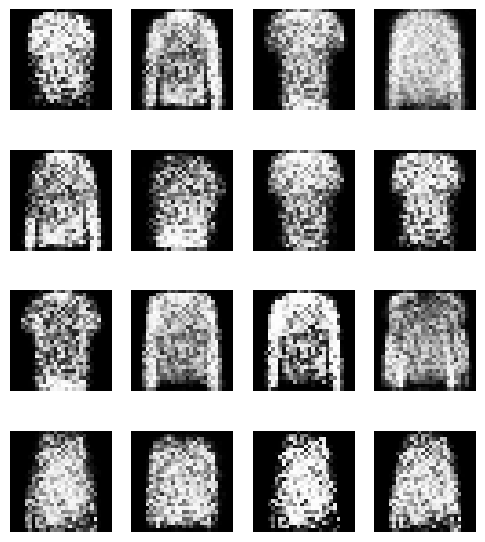

In [14]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

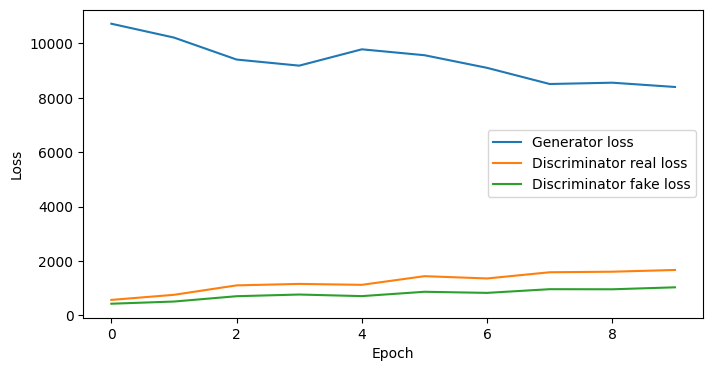

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(ERRG, label="Generator loss")
plt.plot(ERRD_x, label="Discriminator real loss")
plt.plot(ERRD_z, label="Discriminator fake loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


Ванильный ган - медленное обучение

# WGAN

In [16]:
class Discriminator_Wasserstein(nn.Module):
    def __init__(self):
        super(Discriminator_Wasserstein, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)
            )# просто убрала сигмоиду
    def forward(self, x):
        return self.model(x)

In [17]:
discriminator = Discriminator_Wasserstein()
generator = Generator()
optim_G = optim.RMSprop(params=generator.parameters(), lr=0.00005)
optim_D = optim.RMSprop(params=discriminator.parameters(), lr=0.00005)


In [18]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
n_critic = 5
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        for i in range(n_critic):
          #######
          # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
          #######
          discriminator.zero_grad()

          # real
          input_data = images.view(images.shape[0], -1)
          output = discriminator(input_data)
          errD_x = -torch.mean(output)
          ERRD_x[epoch] += errD_x.item()

          # fake
          noise.data.normal_(0, 1)
          fake = generator(noise)
          output = discriminator(fake.detach())
          errD_z = torch.mean(output)
          ERRD_z[epoch] += errD_z.item()


          loss_D = errD_x + errD_z
          loss_D.backward()

          optim_D.step()
          for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        noise.data.normal_(0, 1)
        new_fake = generator(noise)
        output = discriminator(new_fake)

        errG = -torch.mean(output)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: -0.03 errD_z: -0.41 errG: 0.41
Epoch:1 Iter: 200 errD_x: 0.03 errD_z: -0.36 errG: 0.35
Epoch:1 Iter: 300 errD_x: 0.12 errD_z: -0.37 errG: 0.38
Epoch:1 Iter: 400 errD_x: 0.14 errD_z: -0.35 errG: 0.34
Epoch:1 Iter: 500 errD_x: 0.12 errD_z: -0.33 errG: 0.32
Epoch:1 Iter: 600 errD_x: 0.06 errD_z: -0.25 errG: 0.24
Epoch:1 Iter: 700 errD_x: -0.02 errD_z: -0.19 errG: 0.18
Epoch:1 Iter: 800 errD_x: -0.04 errD_z: -0.08 errG: 0.07
Epoch:1 Iter: 900 errD_x: -0.11 errD_z: -0.08 errG: 0.08
Epoch:1 Iter: 1000 errD_x: -0.10 errD_z: -0.03 errG: 0.03
Epoch:1 Iter: 1100 errD_x: -0.07 errD_z: -0.05 errG: 0.06
Epoch:1 Iter: 1200 errD_x: -0.11 errD_z: 0.00 errG: 0.01
Epoch:1 Iter: 1300 errD_x: -0.12 errD_z: -0.00 errG: 0.01
Epoch:1 Iter: 1400 errD_x: -0.10 errD_z: 0.00 errG: -0.00
Epoch:1 Iter: 1500 errD_x: -0.09 errD_z: 0.00 errG: 0.01
Epoch:1 Iter: 1600 errD_x: -0.12 errD_z: 0.01 errG: -0.01
Epoch:1 Iter: 1700 errD_x: -0.15 errD_z: 0.05 errG: -0.06
Epoch:1 Iter: 1800 errD_x: -0.

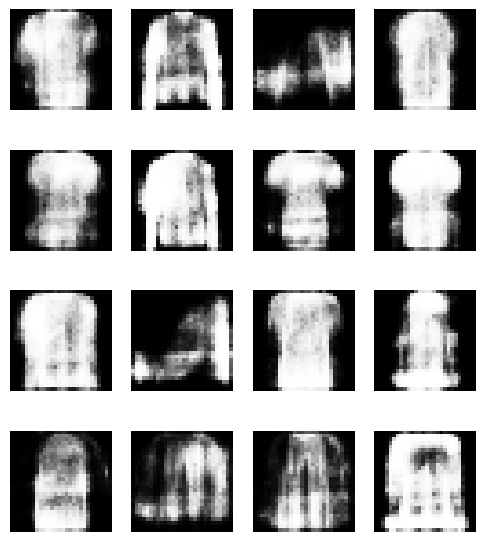

In [19]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

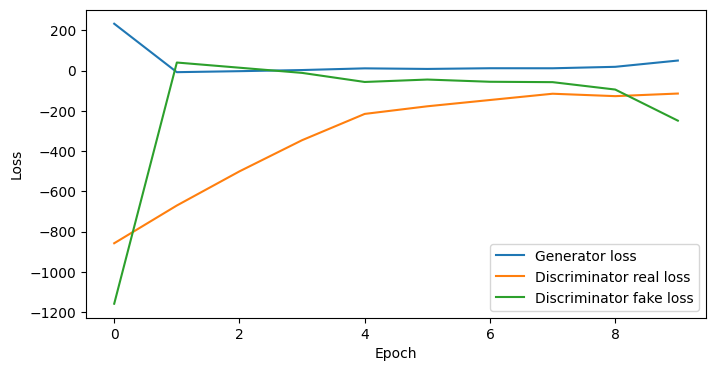

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(ERRG, label="Generator loss")
plt.plot(ERRD_x, label="Discriminator real loss")
plt.plot(ERRD_z, label="Discriminator fake loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


WGAN с weight clipping обучается стабильнее, чем обычный GAN, лосс критика постепенно уменьшается, и генератор начинает воспроизводить базовые формы одежды. картины выглядят размытыми, не все классы одежды различимы, модель медленно сходится.

# Gradient Penalty

In [21]:
discriminator = Discriminator_Wasserstein()
generator = Generator()
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001, betas=(0.5, 0.9))
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001, betas=(0.5, 0.9))


In [22]:
def gradient_penalty(discriminator, real_data, fake_data):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand_as(real_data)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates.requires_grad_(True)

    d_interpolates = discriminator(interpolates)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.view(batch_size, -1)
    penalty = ((gradients.norm(2, dim=1) - 1)**2).mean()

    return penalty


In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
n_critic = 5
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        for i in range(n_critic):
          #######
          # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
          #######
          discriminator.zero_grad()

          # real
          input_data = images.view(images.shape[0], -1)
          output = discriminator(input_data)
          errD_x = -torch.mean(output)
          ERRD_x[epoch] += errD_x.item()

          # fake
          noise.data.normal_(0, 1)
          fake = generator(noise)
          output = discriminator(fake.detach())
          errD_z = torch.mean(output)
          ERRD_z[epoch] += errD_z.item()

          gp = gradient_penalty(discriminator, input_data, fake.detach())

          loss_D = errD_x + errD_z + 10 * gp
          loss_D.backward()

          optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        noise.data.normal_(0, 1)
        new_fake = generator(noise)
        output = discriminator(new_fake)

        errG = -torch.mean(output)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 2.21 errD_z: -11.38 errG: 11.23
Epoch:1 Iter: 200 errD_x: -1.95 errD_z: -4.08 errG: 4.02
Epoch:1 Iter: 300 errD_x: -4.87 errD_z: -0.35 errG: 0.21
Epoch:1 Iter: 400 errD_x: -5.96 errD_z: 0.75 errG: -0.83
Epoch:1 Iter: 500 errD_x: -5.57 errD_z: -0.60 errG: 0.51
Epoch:1 Iter: 600 errD_x: -3.76 errD_z: -0.98 errG: 1.38
Epoch:1 Iter: 700 errD_x: -5.46 errD_z: 0.06 errG: -0.06
Epoch:1 Iter: 800 errD_x: -6.70 errD_z: 1.03 errG: -0.93
Epoch:1 Iter: 900 errD_x: -5.10 errD_z: 0.71 errG: -0.53
Epoch:1 Iter: 1000 errD_x: -6.09 errD_z: 1.11 errG: -1.02
Epoch:1 Iter: 1100 errD_x: -6.41 errD_z: 2.00 errG: -2.02
Epoch:1 Iter: 1200 errD_x: -4.26 errD_z: 0.50 errG: -0.61


In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(ERRG, label="Generator loss")
plt.plot(ERRD_x, label="Discriminator real loss")
plt.plot(ERRD_z, label="Discriminator fake loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# Условная генерация

In [ ]:
label.unique().numel()


7

In [ ]:
num_classes = label.unique().numel()

def onehot(labels, num_classes = label.unique().numel()):
    return F.one_hot(labels, num_classes).float()

In [ ]:
def gradient_penalty(discriminator, real_data, fake_data, labels):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand_as(real_data)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates.requires_grad_(True)

    d_interpolates = discriminator(interpolates, labels)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.view(batch_size, -1)
    penalty = ((gradients.norm(2, dim=1) - 1)**2).mean()

    return penalty


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size+10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid()
            )

    def forward(self, x, y):
        inp = torch.cat([x, y], dim=1)
        return self.model(inp)

class Discriminator_Wasserstein(nn.Module):
    def __init__(self):
        super(Discriminator_Wasserstein, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28 + 10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)
            )# просто убрала сигмоиду
    def forward(self, x, y):
        data = torch.cat([x, y], dim=1)
        return self.model(data)

In [ ]:
discriminator = Discriminator_Wasserstein()
generator = Generator()
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001, betas=(0.5, 0.9))
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001, betas=(0.5, 0.9))


In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
n_critic = 5
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        y_onehot = onehot(cat, 10)
        for i in range(n_critic):
          #######
          # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
          #######
          discriminator.zero_grad()

          # real
          input_data = images.view(images.shape[0], -1)
          output = discriminator(input_data, y_onehot)
          errD_x = -torch.mean(output)
          ERRD_x[epoch] += errD_x.item()

          # fake
          noise.data.normal_(0, 1)
          fake = generator(noise, y_onehot)
          output = discriminator(fake.detach(), y_onehot)
          errD_z = torch.mean(output)
          ERRD_z[epoch] += errD_z.item()

          gp = gradient_penalty(discriminator, input_data, fake.detach(), y_onehot)

          loss_D = errD_x + errD_z + 10 * gp
          loss_D.backward()

          optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        noise.data.normal_(0, 1)
        new_fake = generator(noise, y_onehot)
        output = discriminator(new_fake, y_onehot)

        errG = -torch.mean(output)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 2.55 errD_z: -11.51 errG: 11.50
Epoch:1 Iter: 200 errD_x: -0.91 errD_z: -5.98 errG: 6.01
Epoch:1 Iter: 300 errD_x: -2.00 errD_z: -4.05 errG: 3.90
Epoch:1 Iter: 400 errD_x: -5.55 errD_z: -1.22 errG: 0.93
Epoch:1 Iter: 500 errD_x: -5.04 errD_z: -0.53 errG: 0.48
Epoch:1 Iter: 600 errD_x: -7.87 errD_z: 1.88 errG: -2.17
Epoch:1 Iter: 700 errD_x: -8.15 errD_z: 1.31 errG: -1.32
Epoch:1 Iter: 800 errD_x: -6.27 errD_z: -0.23 errG: -0.07
Epoch:1 Iter: 900 errD_x: -7.22 errD_z: 1.71 errG: -1.67
Epoch:1 Iter: 1000 errD_x: -6.58 errD_z: 1.45 errG: -1.44
Epoch:1 Iter: 1100 errD_x: -8.83 errD_z: 2.08 errG: -2.29
Epoch:1 Iter: 1200 errD_x: -6.38 errD_z: 0.25 errG: 0.10
Epoch:1 Iter: 1300 errD_x: -8.27 errD_z: 2.30 errG: -2.63
Epoch:1 Iter: 1400 errD_x: -9.00 errD_z: 3.44 errG: -3.03
Epoch:1 Iter: 1500 errD_x: -8.32 errD_z: 1.74 errG: -1.91
Epoch:1 Iter: 1600 errD_x: -8.64 errD_z: 3.54 errG: -3.20
Epoch:1 Iter: 1700 errD_x: -10.18 errD_z: 4.00 errG: -3.86
Epoch:1 Iter: 1800 er

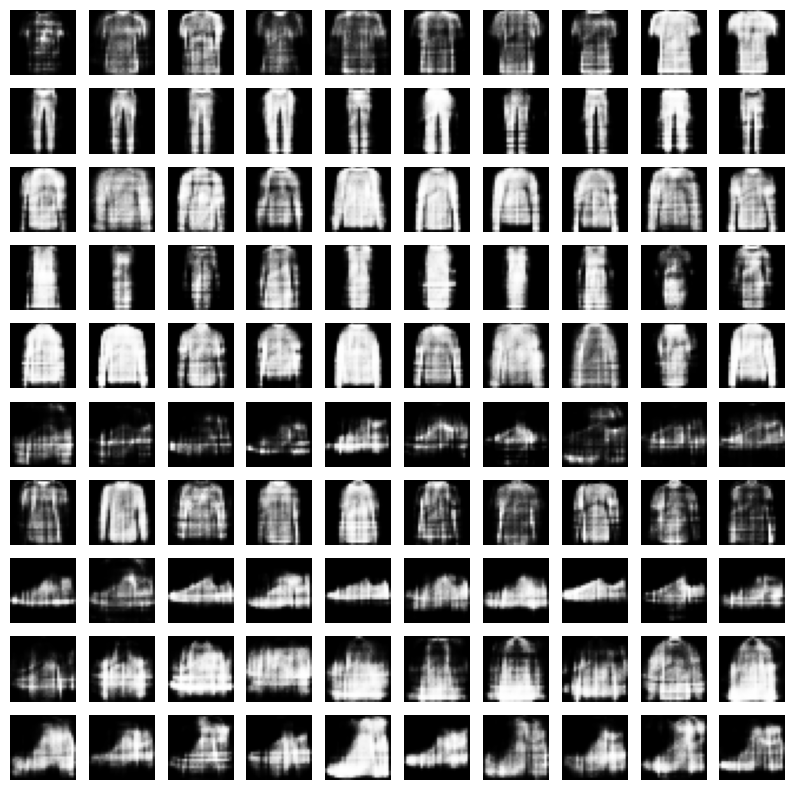

In [ ]:
num_classes = 10
num_per_class = 10
total = num_classes * num_per_class

z = torch.randn(total, config.noise_size)

labels = torch.arange(num_classes).repeat_interleave(num_per_class)
y = F.one_hot(labels, num_classes).float()

fake = generator(z, y)

plt.figure(figsize=(10, 10))
for i in range(total):
    plt.subplot(num_classes, num_per_class, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()


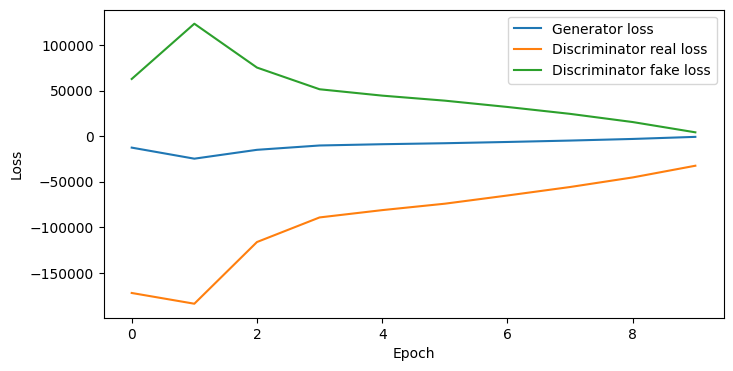

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(ERRG, label="Generator loss")
plt.plot(ERRD_x, label="Discriminator real loss")
plt.plot(ERRD_z, label="Discriminator fake loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
